# Final LDA Model

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from datetime import datetime

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# TF.IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n', 'een', 'naan', 'nde', 'nhij', '\\n'])

# Data Final

In [3]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022_cleaned.csv', index_col=6, parse_dates=['date']) 
df.head()

df_be = df[df['bewijs'] != '[]'] #bewijs
df_te = df[df['tll'] != '[]'] #tenlastelegging

df['bete'] = df['bewijs'] + df['tll'] 
df = df[df['bete'] != '[][]']
df = df.drop(labels=['bewijs', 'tll'], axis=1)


In [4]:
df18 = df.loc["2018-01-01 00:00:00":"2018-12-31 00:00:00"]
df19 = df.loc["2019-01-01 00:00:00":"2019-12-31 00:00:00"]
df20 = df.loc["2020-01-01 00:00:00":"2020-12-31 00:00:00"]
df21 = df.loc["2021-01-01 00:00:00":"2021-12-31 00:00:00"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated 

In [5]:
print(df18.shape)
print(df19.shape)
print(df20.shape)
print(df21.shape)

(300, 7)
(306, 7)
(315, 7)
(527, 7)


# Build Giant Function

In [8]:

def get_lda_model(df):

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(df['bete']))

        # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    nlp = spacy.load("nl_core_news_sm")

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out



    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    # nlp = spacy.load('nl', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # corpus1 = [str(item) for item in corpus]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


    ######## TF.IDF ########

    dat_lem_untok = [" ".join(x) for x in data_lemmatized]
    tfidf_vectorizer = TfidfVectorizer(input=dat_lem_untok, stop_words=stop_words)
    tfidf_vector = tfidf_vectorizer.fit_transform(dat_lem_untok)
    tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())
    tfidf_df = tfidf_df.stack().reset_index()
    tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
    top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

     

    return(lda_model, data_lemmatized, corpus, id2word, top_tfidf)

In [9]:
d = [df18, df19, df20, df21]
q = 1
lda_models = []
dat_lems = []
corps = []
ids = []
top_idfs = []

for i in d:
    print(q)
    q += 1
    l, dl, c, i2words, t = get_lda_model(i)
    lda_models.append(l)
    dat_lems.append(dl)
    corps.append(c)
    ids.append(i2words)
    top_idfs.append(t)



1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tenlastelegging'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


2
3
4


In [13]:
d[3]

,Unnamed: 0,filename,ecli,subject,spatial,case_nr,bete
date,,,,,,,
2021-02-10,7,ECLI_NL_RBOVE_2021_606.xml,ECLI:NL:RBOVE:2021:606,Strafrecht,Almelo,08/760218-17 (P),"[][' tenlastelegging de verdenking komt er, ..."
2021-02-10,8,ECLI_NL_GHSHE_2021_1801.xml,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,[' bewijsmiddelen indien tegen dit ve...
2021-02-09,16,ECLI_NL_RBROT_2021_2966.xml,ECLI:NL:RBROT:2021:2966,Strafrecht,Rotterdam,10.295806.20,[' bewijswaardering 4.1.1. standpunt verd...
2021-02-02,28,ECLI_NL_RBAMS_2021_378.xml,ECLI:NL:RBAMS:2021:378,Strafrecht,Amsterdam,13/701115-19,[][' 2tenlastelegging aan verdachte is – ko...
2021-02-23,43,ECLI_NL_GHDHA_2021_497.xml,ECLI:NL:GHDHA:2021:497,Strafrecht,Den Haag,2200469519,[' bewijsvoering het hof grondt zijn ...
...,...,...,...,...,...,...,...
2021-02-03,2882,ECLI_NL_RBROT_2021_1286.xml,ECLI:NL:RBROT:2021:1286,Strafrecht,Rotterdam,10/750172-20,[][' tenlastelegging aan de verdachte word...
2021-02-25,2898,ECLI_NL_RBZWB_2021_786.xml,ECLI:NL:RBZWB:2021:786,Strafrecht,Middelburg,02-220946-20,[][' tenlastelegging de tenlastelegging is ge...
2021-02-25,2902,ECLI_NL_RBNHO_2021_1491.xml,ECLI:NL:RBNHO:2021:1491,Strafrecht,Haarlem,15/246961-19,[][' 1tenlastelegging aan verdachte is ten l...


# Compute Model Perplexity and Coherence Score

In [14]:
# 18 = 0 / 19 = 1 / 20 = 2 / 21 = 3

a = 3

# Compute Perplexity
print('\nPerplexity: ', lda_models[a].log_perplexity(corps[a]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_models[a], texts=dat_lems[a], dictionary=ids[a], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.165643207444637

Coherence Score:  0.42405226061954854


# Visualize the topics-keywords

In [15]:
# 18 = 0 / 19 = 1 / 20 = 2 / 21 = 3

a = 3

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_models[a], corps[a], ids[a], R = 10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.014406  0.104510       1        1  30.438842
4     -0.088183  0.051994       2        1  21.956066
0      0.125511  0.100430       3        1  20.492158
3      0.162469 -0.155660       4        1  14.200537
2     -0.185390 -0.101275       5        1  12.912397, topic_info=                Term         Freq         Total Category  logprob  loglift
590      slachtoffer  7332.000000   7332.000000  Default  10.0000  10.0000
28              naam  5330.000000   5330.000000  Default   9.0000   9.0000
118              hof  2007.000000   2007.000000  Default   8.0000   8.0000
870        benadelen  2633.000000   2633.000000  Default   7.0000   7.0000
2726  telefoonnummer  1339.000000   1339.000000  Default   6.0000   6.0000
...              ...          ...           ...      ...      ...      ...
41         verdenken  1341.868737  13136.401438   Topic5  -3.4839  -0.2343
6              ander   526.485288   2735.727345   Topic5  -4.4195   0.3991
17             geval   408.273177   1542.597397   Topic5  -4.6738   0.7177
209            weten   447.350232   1988.382306   Topic5  -4.5824   0.5552
551     medeverdacht   399.100342   2730.392062   Topic5  -4.6965   0.1240

[141 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
463       1  0.991781         aangeefster
463       3  0.007779         aangeefster
732       1  0.891033            aangever
732       2  0.028012            aangever
732       3  0.056023            aangever
...     ...       ...                 ...
640       2  0.153515              zitten
640       3  0.641421              zitten
640       4  0.033439              zitten
640       5  0.012160              zitten
879       1  0.995217  zware_mishandeling

[289 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

# TF.IDF 

In [16]:
test = top_idfs[0].sort_values(by=['tfidf'], ascending=[False]).head(20)

In [25]:
top_idfs[3].sort_values(by=['tfidf'], ascending=[False]).head(20)

,document,term,tfidf
4970700,391,gemeente,0.988007
5451132,429,bijnaam,0.880386
5692489,448,bijnaam,0.878411
6380733,502,gemeente,0.802755
2874705,226,gemeente,0.802755
6215594,489,gemeente,0.802755
2743893,216,aangeefster,0.800554
3992569,314,gemeente,0.742708
2196638,172,voornaam,0.739514
482768,38,aangever,0.736274


In [29]:
top_idfs[3][top_idfs[3]['term'].str.contains('hof')]

,document,term,tfidf
17253,1,hof,0.547426
55362,4,hof,0.490788
169689,13,hof,0.303109
195095,15,hof,0.444318
207798,16,hof,0.177091
245907,19,hof,0.333794
322125,25,hof,0.402263
334828,26,hof,0.157184
588888,46,hof,0.201870
626997,49,hof,0.239246


In [30]:
values = []
term = 'slachtoffer'

def avg_terms(data, term):
    avg = data[data['term'].str.contains(term)]['tfidf'].mean()
    return(avg)
    
for i in top_idfs:
    a  = avg_terms(i, term)
    values.append(a)

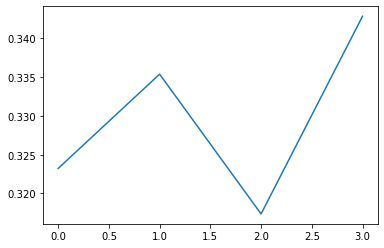

In [34]:
plt.plot(values)